In [1]:
import torchvision
import torch
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescent
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from torchvision import transforms
from torchvision.io import read_image
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.utils import random_sphere
from art.config import ART_NUMPY_DTYPE
import numpy as np
from torchvision.transforms import v2
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import os
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, vgg19 , VGG19_Weights, resnet18, ResNet18_Weights, densenet121,  densenet121, DenseNet121_Weights, vit_b_16, ViT_B_16_Weights, efficientnet_b2, EfficientNet_B2_Weights,  swin_s, Swin_S_Weights, convnext_base, ConvNeXt_Base_Weights

/home/baravrah/.conda/envs/gpu_test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/baravrah/.conda/envs/gpu_test/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/baravrah/.conda/envs/gpu_test/lib/python3.8/

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
models = [("vit_b_16",vit_b_16, ViT_B_16_Weights),
          ("efficientnet_b0" , efficientnet_b0, EfficientNet_B0_Weights),
          ("swin_s", swin_s, Swin_S_Weights),
          ("densenet121" , densenet121, DenseNet121_Weights),
          ("resnet18" ,resnet18, ResNet18_Weights)]

In [4]:
class model_with_normalization(nn.Module):
    def __init__(self, model, normalization):
        super(model_with_normalization, self).__init__()
        self.model = model
        self.normalization = normalization

    def forward(self, x):
        x = self.normalization(x)
        if x.shape == (3,224,224):
          x = x.unsqueeze(0)
        out = self.model(x)
        return out

normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

In [5]:
class CustomDataset(Dataset):
    def __init__(self):
        self.data = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Initialize your custom dataset
new_dataset = CustomDataset()

In [6]:
def read_image(image_path):
    return Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])

In [7]:
import pickle
import random
from torch.cuda.amp import autocast

trans = [
    transforms.RandomAffine(degrees=(-2, 2), translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(size=(224, 224), padding=10),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast()]


augmentations = transforms.Compose(trans)
batch_size = 100

In [8]:
d = {'RandomAffine': [],
            'ColorJitter': [],
            'RandomHorizontalFlip': [],
            'RandomCrop': [],
            'GaussianBlur': [],
            'RandomAdjustSharpness': [],
            'RandomAutocontrast': []}

In [9]:
results = {}
from torchattacks import PGD
for i , (name_v, model_v, weights_v) in enumerate(models):
    if i!=0:
        continue
    victim = model_v(weights=weights_v.DEFAULT)
    print("______________________")
    print("Victim: "+ name_v)

    S = models.copy()
    S.pop(i)
    victim = model_with_normalization(victim, normalization)
    victim.eval()
    victim = victim.to(device)

    with open('../data_'+name_v+'1000images.pkl', 'rb') as f:
        new_data_loader = pickle.load(f)
    for batch , (images, labels) in enumerate(new_data_loader):
                   if batch==0:
                        break
    #new_data_loader = DataLoader(new_data_loader.dataset, batch_size=batch_size, shuffle=True)
    d_copy = {'RandomAffine': [],
            'ColorJitter': [],
            'RandomHorizontalFlip': [],
            'RandomCrop': [],
            'GaussianBlur': [],
            'RandomAdjustSharpness': [],
            'RandomAutocontrast': []}
    all_g = []
    for j , (name_g,model_g, weights_g) in enumerate(S):
               print("g: "+ name_g)
               all_g.append(name_g)
               g = model_g(weights=weights_g.DEFAULT)
               Se = S.copy()
               Se.pop(j)
               g = model_with_normalization(g, normalization)
               g.eval()

               
               for k, aug in enumerate(d):
                    
                    augmentation_confidences = []
                    augmentation_success = []
                    for _ in range(200):

                          #PGD_attack = ProjectedGradientDescentPyTorch(estimator=clf, max_iter=random.randint(10, 20) , eps=12.75/255 , num_random_init=1)
                          PGD_attack = PGD(g, eps=12.75/255, alpha=random.uniform(0.1/255, 0.3/255), steps =random.randint(10, 20), random_start=True)

                          #one augmentation
                          x_o = trans[k](images)
                        
                          x_o = PGD_attack(x_o, labels)
                          adv_label_o = victim(x_o).argmax(dim=1)
                          adv_label_o = adv_label_o.to('cpu')

                          torch.cuda.empty_cache()
                          del PGD_attack

                          average_confidences_o =  np.zeros(batch_size, dtype=np.float32)
                          for n , model_s, weights_s in Se:

                              model = model_s(weights=weights_s.DEFAULT)
                              model = model.to(device)
                              model = model_with_normalization(model, normalization)
                              model.eval()

                              outputs_o = model(x_o).softmax(dim=1)
                              confidences_o = outputs_o[torch.arange(outputs_o.size(0)),labels].detach().cpu().numpy()
                              average_confidences_o += confidences_o

                              outputs_o = outputs_o.to('cpu')
                              # confidences_o = confidences_o.to('cpu')
                              model = model.to('cpu')
                              del outputs_o
                              del confidences_o
                              del model


                              torch.cuda.empty_cache()

                          x_o = x_o.to('cpu')
                          del x_o


                          average_confidences_o /= len(Se)

                          equality_tensor_o = (labels != adv_label_o).int()

                          augmentation_confidences.append(average_confidences_o)
                          augmentation_success.append(equality_tensor_o)

                          torch.cuda.empty_cache()

                    merged_results_o = [tuple(zip(np.array(augmentation_confidences)[:, i], torch.stack(augmentation_success).numpy()[:, i]))
                          for i in range(batch_size)]

                      # Sort the merged results based on the mean confidence for each image
                    sorted_results_o = [sorted(image_results, key=lambda x: x[0], reverse=False) for image_results in merged_results_o]


                    best_result = 0
                    random_result = 0
                    for sublist in sorted_results_o:
                          # Increment the best result based on the first item's binary value
                          best_result += sublist[0][1]
                          # Calculate the sum of random items in each sublist
                          random_result += random.choice(sublist)[1]
                    d_copy[aug].append(best_result)
                    print("Best Result(one augmentation):", best_result)
                    print("Random Result(one augmentation):", random_result)
                    print(d_copy)
               #break     
    # d_copy['g'] = all_g                                
    # results[name_v]=d_copy
    # with open('which_augs/'+name_v+'.pkl', 'wb') as f:
    #     pickle.dump(d_copy, f)
                                    
                              

______________________
Victim: vit_b_16
g: efficientnet_b0


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [16]:
results = {'vit_b_16': {'RandomAffine': [12, 19, 20, 15], 'ColorJitter': [18, 20, 14, 19], 'RandomHorizontalFlip': [10, 14, 11, 9], 'RandomCrop': [11, 19, 16, 10], 'GaussianBlur': [19, 22, 21, 21], 'RandomAdjustSharpness': [11, 20, 12, 10], 'RandomAutocontrast': [6, 17, 12, 11]
  ,'g': ['efficientnet_b0', 'swin_s', 'densenet121', 'resnet18']},
 'efficientnet_b0':{'RandomAffine': [32, 29, 38, 19], 'ColorJitter': [37, 28, 38, 25], 'RandomHorizontalFlip': [26, 23, 31, 13], 'RandomCrop': [27, 24, 31, 18], 'GaussianBlur': [44, 36, 46, 28], 'RandomAdjustSharpness': [27, 22, 31, 14], 'RandomAutocontrast': [22, 21, 30, 16],
  'g': ['vit_b_16', 'swin_s', 'densenet121', 'resnet18']},
 'swin_s':{'RandomAffine': [32, 21, 19, 16], 'ColorJitter': [36, 18, 21, 15], 'RandomHorizontalFlip': [27, 22, 10, 15], 'RandomCrop': [26, 18, 12, 13], 'GaussianBlur': [47, 34, 24, 19], 'RandomAdjustSharpness': [25, 20, 12, 10], 'RandomAutocontrast': [28, 17, 9, 12],
  'g': ['vit_b_16', 'efficientnet_b0', 'densenet121', 'resnet18']},
 'densenet121': {'RandomAffine': [31, 37, 28, 30], 'ColorJitter': [38, 39, 32, 34], 'RandomHorizontalFlip': [28, 33, 26, 28], 'RandomCrop': [29, 31, 25, 30], 'GaussianBlur': [43, 48, 33, 33], 'RandomAdjustSharpness': [22, 27, 22, 28], 'RandomAutocontrast': [21, 31, 21, 27],
  'g': ['vit_b_16', 'efficientnet_b0', 'swin_s', 'resnet18']},
 'resnet18': {'RandomAffine': [31, 45, 27, 43], 'ColorJitter': [35, 49, 33, 41], 'RandomHorizontalFlip': [26, 44, 28, 37], 'RandomCrop': [30, 44, 23, 38], 'GaussianBlur': [40, 55, 32, 59], 'RandomAdjustSharpness': [27, 39, 27, 43], 'RandomAutocontrast': [29, 35, 28, 39],
  'g': ['vit_b_16', 'efficientnet_b0', 'swin_s', 'densenet121']}}

In [10]:
import pickle
models = ["vit_b_16", "efficientnet_b0", "swin_s", "densenet121", "resnet18"]
results = {}
for i , name_v in enumerate(models):
    with open('which_augs/'+name_v+'.pkl', 'rb') as f:
        result = pickle.load(f)
        results[name_v] = result

In [27]:
all = {}
for i , name_v in enumerate(models):
    S = models.copy()
    S.pop(i)
    for j , name_g in enumerate(S):
        with open('sample_size_which_aug/A'+str(1)+name_v+'_'+name_g+'.pkl', 'rb') as f:
            result = pickle.load(f)
            all[(i,j)]=result[200][0]
all

{(0, 0): 0.27,
 (0, 1): 0.24,
 (0, 2): 0.26,
 (0, 3): 0.26,
 (1, 0): 0.31,
 (1, 1): 0.34,
 (1, 2): 0.34,
 (1, 3): 0.33,
 (2, 0): 0.36,
 (2, 1): 0.38,
 (2, 2): 0.32,
 (2, 3): 0.29,
 (3, 0): 0.4,
 (3, 1): 0.47,
 (3, 2): 0.37,
 (3, 3): 0.45,
 (4, 0): 0.48,
 (4, 1): 0.63,
 (4, 2): 0.45,
 (4, 3): 0.64}

In [28]:
all = {}
for i , name_v in enumerate(models):
    S = models.copy()
    S.pop(i)
    for j , name_g in enumerate(S):
        with open('sample_size_which_aug/A'+str(1)+name_v+'_'+name_g+'.pkl', 'rb') as f:
            result = pickle.load(f)
            all[(i,j)]=result[1][0]
all

{(0, 0): 0.2,
 (0, 1): 0.22,
 (0, 2): 0.15,
 (0, 3): 0.15,
 (1, 0): 0.21,
 (1, 1): 0.18,
 (1, 2): 0.22,
 (1, 3): 0.23,
 (2, 0): 0.25,
 (2, 1): 0.25,
 (2, 2): 0.19,
 (2, 3): 0.21,
 (3, 0): 0.27,
 (3, 1): 0.33,
 (3, 2): 0.27,
 (3, 3): 0.34,
 (4, 0): 0.27,
 (4, 1): 0.48,
 (4, 2): 0.32,
 (4, 3): 0.43}

In [16]:
#Assuming this is the correct path and the file exists
with open('which_augs_results.pkl', 'rb') as f:
    results = pickle.load(f)
results

{'vit_b_16': {'RandomAffine': [12, 19, 20, 15],
  'ColorJitter': [18, 20, 14, 19],
  'RandomHorizontalFlip': [10, 14, 11, 9],
  'RandomCrop': [11, 19, 16, 10],
  'GaussianBlur': [19, 22, 21, 21],
  'RandomAdjustSharpness': [11, 20, 12, 10],
  'RandomAutocontrast': [6, 17, 12, 11],
  'g': ['efficientnet_b0', 'swin_s', 'densenet121', 'resnet18']},
 'efficientnet_b0': {'RandomAffine': [32, 29, 38, 19],
  'ColorJitter': [37, 28, 38, 25],
  'RandomHorizontalFlip': [26, 23, 31, 13],
  'RandomCrop': [27, 24, 31, 18],
  'GaussianBlur': [44, 36, 46, 28],
  'RandomAdjustSharpness': [27, 22, 31, 14],
  'RandomAutocontrast': [22, 21, 30, 16],
  'g': ['vit_b_16', 'swin_s', 'densenet121', 'resnet18']},
 'swin_s': {'RandomAffine': [32, 21, 19, 16],
  'ColorJitter': [36, 18, 21, 15],
  'RandomHorizontalFlip': [27, 22, 10, 15],
  'RandomCrop': [26, 18, 12, 13],
  'GaussianBlur': [47, 34, 24, 19],
  'RandomAdjustSharpness': [25, 20, 12, 10],
  'RandomAutocontrast': [28, 17, 9, 12],
  'g': ['vit_b_16', '

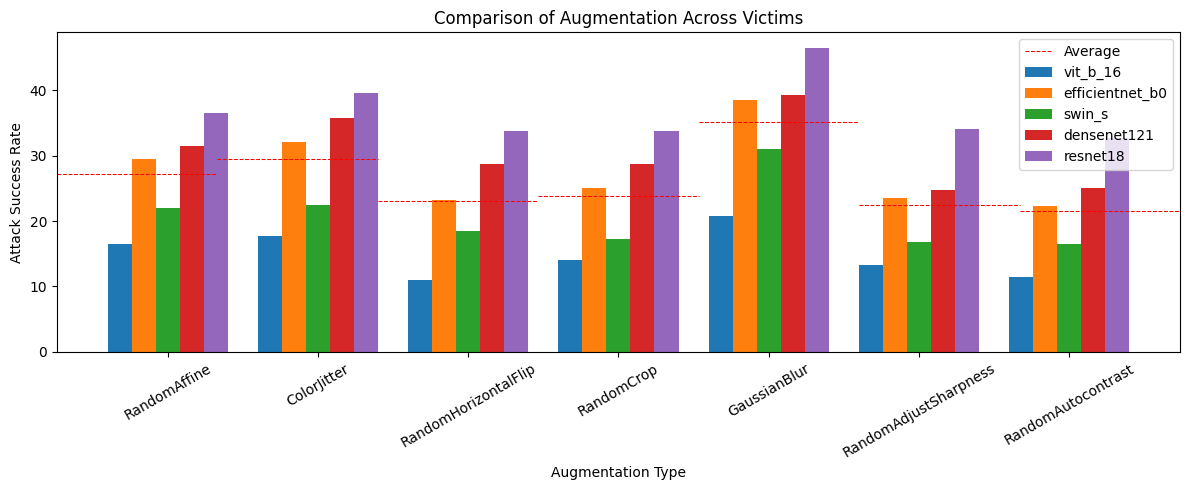

In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Assuming this is the correct path and the file exists
# with open('which_augs_results.pkl', 'rb') as f:
#     results = pickle.load(f)

models = ["vit_b_16", "efficientnet_b0", "swin_s", "densenet121", "resnet18"]
augmentation_types = list(results['vit_b_16'].keys())[:-1]  # Excluding the last augmentation type if necessary

# Setup for multiple bar groups
total_width = 0.8
single_width = total_width / len(models)
bar_positions = np.arange(len(augmentation_types))

fig, ax = plt.subplots(figsize=(12, 5))

average_values = []
for aug in augmentation_types:
    # Compute average for each list within aug_values before aggregating
    aug_values = [np.mean(results[model][aug]) if isinstance(results[model][aug], list) and results[model][aug] else 0 for model in models]
    avg_value = np.mean(aug_values)
    average_values.append(avg_value)

# Adding average values to the plot as horizontal lines
for i, avg_value in enumerate(average_values):
    ax.axhline(y=avg_value, xmin=(i / len(augmentation_types)), xmax=((i + 1) / len(augmentation_types)),
               color='r', linestyle='--', linewidth=0.75, label='Average' if i == 0 else "")

# Plotting bars for each model
for i, model in enumerate(models):
    values = [np.mean(results[model][aug]) if isinstance(results[model][aug], list) else 0 for aug in augmentation_types]
    positions = bar_positions + (i - len(models) / 2) * single_width + single_width / 2
    ax.bar(positions, values, single_width, label=model)

ax.set_xticks(bar_positions)
ax.set_xticklabels(augmentation_types, rotation=30)
ax.set_xlabel('Augmentation Type')
ax.set_ylabel('Attack Success Rate')
ax.set_title('Comparison of Augmentation Across Victims')
ax.legend()

plt.tight_layout()
plt.show()


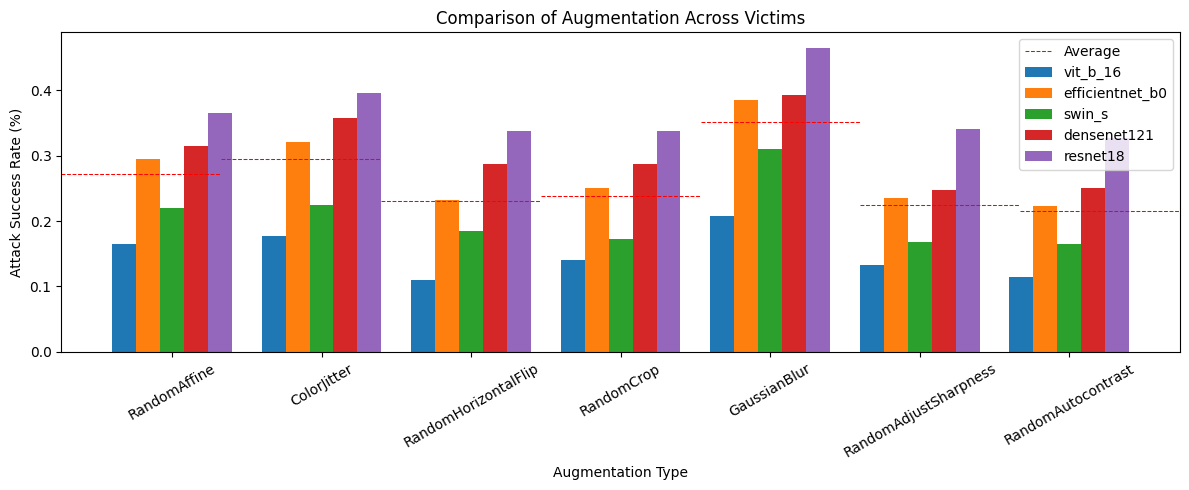

In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Assuming this is the correct path and the file exists
# with open('../which_augs_results_comb2.pkl', 'rb') as f:
#     results = pickle.load(f)

models = ["vit_b_16", "efficientnet_b0", "swin_s", "densenet121", "resnet18"]
augmentation_types = list(results['vit_b_16'].keys())[:-1]  # Excluding the last augmentation type if necessary

# Setup for multiple bar groups
total_width = 0.8
single_width = total_width / len(models)
bar_positions = np.arange(len(augmentation_types))

fig, ax = plt.subplots(figsize=(12, 5))

average_values = []
for aug in augmentation_types:
    # Compute average for each list within aug_values before aggregating
    aug_values = [np.mean(results[model][aug]) / 100 if isinstance(results[model][aug], list) and results[model][aug] else 0 for model in models]
    avg_value = np.mean(aug_values)
    average_values.append(avg_value)

# Adding average values to the plot as horizontal lines
for i, avg_value in enumerate(average_values):
    ax.axhline(y=avg_value, xmin=(i / len(augmentation_types)), xmax=((i + 1) / len(augmentation_types)),
               color='r', linestyle='--', linewidth=0.75, label='Average' if i == 0 else "")

# Plotting bars for each model
for i, model in enumerate(models):
    values = [np.mean(results[model][aug]) / 100 if isinstance(results[model][aug], list) else 0 for aug in augmentation_types]
    positions = bar_positions + (i - len(models) / 2) * single_width + single_width / 2
    ax.bar(positions, values, single_width, label=model)

ax.set_xticks(bar_positions)
ax.set_xticklabels(augmentation_types, rotation=30)
ax.set_xlabel('Augmentation Type')
ax.set_ylabel('Attack Success Rate (%)')  # Updated to indicate percentages
ax.set_title('Comparison of Augmentation Across Victims')
ax.legend()

plt.tight_layout()
plt.show()
